In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import sys

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

base_path = f'{Path.home()}/SageMaker'
print(base_path)
%ls $base_path

/home/ec2-user/SageMaker
3DDFA_V2/          Face_Seg/             photometric_optimization/  train_data/
autostop.py        lost+found/           pretrained_models/         train.py
cron-shutdown.sh*  mean_landmarks.ipynb  __pycache__/               train_v2.py
custom-miniconda/  model.py              setup.ipynb                utils.ipynb
data/              on-start.sh*          stylegan2_pytorch/


In [4]:
sys.path.append(f'{base_path}/photometric_optimization/models')
# from models.RigNet import RigNet
from models.RigNet_v2 import RigNet

In [5]:
import pprint

pprint.pprint(sys.path)

['',
 '/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/my_pytorch17_py36/lib/python36.zip',
 '/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/my_pytorch17_py36/lib/python3.6',
 '/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/my_pytorch17_py36/lib/python3.6/lib-dynload',
 '/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/my_pytorch17_py36/lib/python3.6/site-packages',
 '/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/my_pytorch17_py36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ec2-user/.ipython',
 '/home/ec2-user/SageMaker/photometric_optimization/models']


## Helper funcs

In [6]:
def normalize_float_img(x):
#     if len(x.size()) > 3:
#         x = x.squeeze()
    return x.mul_(127.5/255.).add_(0.5)


def convert_to_uint8(images, dims=None):
    if dims is not None:
        images = F.interpolate(images, (256, 256))

    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    scale = 255 / 2
    images = images.mul(scale) \
            .add_(0.5 + scale) \
            .clamp(0, 255) \
            .permute(0, 2, 3, 1) \
            .to('cpu', torch.uint8) \
            .squeeze()
    return images

## Instantiate models with pre-trained weights
- DFR regressor
- Generator (StyleGAN2)
- RigNet

In [7]:
import load

# del dfr/
dfr = load.dfr(base_path, load_weights=True, training=False).cuda()

Output params dims:  236
Loading weights...  /home/ec2-user/SageMaker/pretrained_models/dfr_ckpt_epoch000499.pt
	DFR model in eval mode...


In [10]:
# del g_ema
g_ema = load.generator(base_path).cuda()

path to StyleGAN2 weights:  /home/ec2-user/SageMaker/pretrained_models/stylegan2-ffhq-config-f.pt
Loading weights...  /home/ec2-user/SageMaker/pretrained_models/stylegan2-ffhq-config-f.pt


In [11]:
# For later use in forming images.
#
w_mean = g_ema.mean_latent(int(5e3)) # For truncation.
noise = g_ema.make_noise()

In [22]:
del rignet


model_name = './test_results/08-03-2021_09.46.31/ringnet_ckpt_epoch000900.pt'

rignet = RigNet()
# one_hot = True
# rignet = RigNet(one_hot=one_hot)    
# # local_path_to_model = f'{base_path}/pretrained_models' 
# # path_to_weights_rignet = f'{local_path_to_model}/{model_name}'


path_to_weights_rignet = f'{model_name}'
print("Loading weights... ", path_to_weights_rignet)
rignet.load_state_dict(torch.load(path_to_weights_rignet)['rignet'], strict=True)
rignet = rignet.cuda()
rignet.eval();

Loading weights...  ./test_results/08-03-2021_09.46.31/ringnet_ckpt_epoch000900.pt


In [23]:
# model_losses = './test_results/06-03-2021_11.30.47/losses_epoch002999.pt'
# loss = torch.load(model_losses)
# print(loss.keys())


In [24]:
# plt.plot(loss['landmark_2d']); plt.show()
# plt.plot(loss['pose_reg']); plt.show()
# plt.plot(loss['all_loss'])
# # loss['landmark_2d']

## Test on training data

In [44]:
# index = 52
index = 89
filename = str(index).zfill(6) + '.pkl'
train_dir = f'{base_path}/train_data'
A = torch.load(f'{train_dir}/testing_A/{filename}')
B = torch.load(f'{train_dir}/testing_B/{filename}')


w_A = A['latents'].cuda().unsqueeze(0) # Add in batch dimension
landmarks_2d_gt_A = A['landmarks_2d_gt'].cuda()
images_A = A['images'].cuda()
image_masks_A = A['image_masks'].cuda()


w_B = B['latents'].cuda().unsqueeze(0) # Add in batch dimension
landmarks_2d_gt_B = B['landmarks_2d_gt'].cuda()
images_B = B['images'].cuda()
image_masks_B = B['image_masks'].cuda()


# print(w_A.shape)
# print(w_B.shape)
# print(w_A.view(1, -1).shape)
p_A = dfr(w_A.view(1, -1))
p_B = dfr(w_B.view(1, -1))


# onehot_pose = F.one_hot(torch.tensor([5]), 6)
# labels_in = torch.cat((onehot_pose, onehot_expr), dim=0).cuda()
labels_in = F.one_hot(torch.tensor([1]), 6).cuda()
labels_in = labels_in.expand(1, -1, -1)
# print("labels_in: ", labels_in)


# w_AB = rignet(w_A.clone(), p_B, labels_in)
# w_BA = rignet(w_B.clone(), p_A, labels_in)
semantic_param = 2 # pose
w_AB = rignet(w_A, p_B[semantic_param])
w_BA = rignet(w_B, p_A[semantic_param])

In [45]:
kwargs = {
    'truncation_latent': w_mean,
    'truncation': 0.55,
    'noise': noise,
    'randomize_noise': False,
    'input_is_latent': True,
    'return_latents': False
}


I_a, _ = g_ema([w_A], **kwargs)
I_b, _ = g_ema([w_B], **kwargs)
I_ab, _ = g_ema([w_AB], **kwargs)
I_ba, _ = g_ema([w_BA], **kwargs)


dims = (512, 512)
I_a = convert_to_uint8(I_a, dims)
I_b = convert_to_uint8(I_b, dims)
I_ab = convert_to_uint8(I_ab, dims)
I_ba = convert_to_uint8(I_ba, dims)

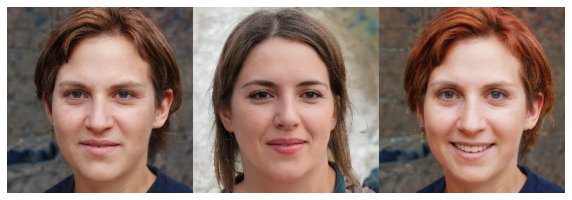

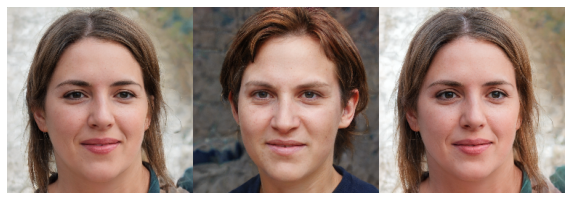

In [46]:
res_ab = np.concatenate([I_a, I_b, I_ab], axis=1)
res_ba = np.concatenate([I_b, I_a, I_ba], axis=1)
plt.figure(figsize=(10,5))
plt.imshow(res_ab); plt.axis('off'); plt.show()
plt.figure(figsize=(10,5))
plt.imshow(res_ba); plt.axis('off'); plt.show()

---
---

## Test on unseen data

### 1, 2)

In [ ]:
W_a = g_ema.get_latent(torch.randn((1, 18, 512)).cuda())
W_b = g_ema.get_latent(torch.randn((1, 18, 512)).cuda())

### 3)

In [ ]:
# # shape, expression, pose, tex, cam, lights = dfr(batch_latents.view(3,-1))
# # print(shape.shape)
# # print(expression.shape)
# # print(pose.shape)
# # print(tex.shape)
# # print(cam.shape)
# # print(lights.shape)

P_a = dfr(W_a.view(1,-1))
P_b = dfr(W_b.view(1,-1))


### 4)

In [ ]:
onehot_pose = F.one_hot(torch.tensor([5]), 6).unsqueeze(0)
# labels_in = torch.cat((onehot_pose, onehot_expr), dim=0).cuda()
labels_in = onehot_pose.cuda()
# labels_in = labels_in.expand(args.batch_size, -1, -1)
print("labels_in: ", labels_in)

W_ab = rignet(W_a, P_b, labels_in)
W_ba = rignet(W_b, P_a, labels_in)
# W_ab = rignet(W_a, P_a, labels_in)
# W_ba = rignet(W_b, P_b, labels_in)


### 5)

In [ ]:
w_mean = g_ema.mean_latent(int(5e3)) # For truncation.
noise = g_ema.make_noise()

In [ ]:



kwargs = {
    'truncation_latent': w_mean,
    'truncation': 0.35,
    'noise': noise,
    'randomize_noise': False,
    'input_is_latent': True,
    'return_latents': False
}

I_a, _ = g_ema([W_a], **kwargs)
I_b, _ = g_ema([W_b], **kwargs)
I_ab, _ = g_ema([W_ab], **kwargs)
I_ba, _ = g_ema([W_ba], **kwargs)

dims = (512, 512)
I_a = convert_to_uint8(I_a, dims)
I_b = convert_to_uint8(I_b, dims)
I_ab = convert_to_uint8(I_ab, dims)
I_ba = convert_to_uint8(I_ba, dims)





In [ ]:
res_ab = np.concatenate([I_a, I_b, I_ab], axis=1)
res_ba = np.concatenate([I_b, I_a, I_ba], axis=1)
plt.figure(figsize=(10,5))
plt.imshow(res_ab); plt.axis('off'); plt.show()
plt.figure(figsize=(10,5))
plt.imshow(res_ba); plt.axis('off'); plt.show()

## Implement the various RigNet losses
**Reconstruction loss**
- Ensure can faithfully reproduce latent codes in the training corpus
- Want to ensure $RigNet(w,F(w)) = w$
- Use the following $l_{2}-loss$ <br>
$L_{rec} = ||RigNet(w, F(w)) - w ||_{2}^{2}$

In [ ]:
# Generate the training corpus for reconstruction loss
#
batch_size = 1000
z = torch.randn((batch_size, 18, 512)).to(device)
# with torch.no_grad():
#     w_plus = g_ema.get_latent(z)
    
w_plus = g_ema.get_latent(z).detach()

print(w_plus.shape)

In [ ]:
rignet = RigNet().cuda()
dfr = load.dfr(base_path, device)

optimizer = Adam(rignet.parameters(), lr=1e-3) # default Adam # Trains
# optimizer = Adadelta(rignet.parameters(), lr=0.001) # default Adadelta # Does not train??
# optimizer = SGD(rignet.parameters(), lr=.1, momentum=.9) # default SGD # Trains
# optimizer = RMSprop(rignet.parameters()) # default RMSprop # Trains
# optimizer = ASGD(rignet.parameters()) # default ASGD # Does not train??
# optimizer = Adamax(rignet.parameters()) # default Adamax # Trains

In [ ]:
# Create a dataloader to batch up latents in consumable chunks.
#
from torch.utils.data import DataLoader

batch_size = 10
loader = DataLoader(w_plus, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
epochs = 30

# pbar = tqdm(range(0, epochs), dynamic_ncols=True, smoothing=0.01)
pbar = trange(epochs, dynamic_ncols=True, smoothing=0.01)
for epoch in pbar:
    for step, w in enumerate(loader):
        p = dfr(w.view(batch_size, -1))
        w_hat = rignet(w, p)

        # L2-loss
        #
        optimizer.zero_grad()
        loss = (w_hat - w).abs().square().mean()
        loss.backward()
        optimizer.step()

        pbar.set_description
        (
            (
                f"total: {loss:.4f}; recon: {loss:.4f}; "
            )
        )
        
    print(loss.item())


---
---

#### Cycle-consistent editing loss
1. Create small dataset in memory to test
    - latents **w** and **v**
    - corresponding pose parameters **$p_{w}$** and **$p_{v}$**
    - corresponding images **$I_{w}$** and **$I_{v}$**
    - landmarks, masks, etc.

In [ ]:
from torch.optim import SGD, Adam, Adadelta, Adagrad, Adamax, ASGD, LBFGS, RMSprop, Rprop
from tqdm.auto import tqdm, trange
# from tqdm import tqdm_notebook as tqdm

#optimizer = Adam(model.parameters(), lr=1e-3) # default Adam
# optimizer = SGD(model.parameters(), lr=.1, momentum=.9) # default SGD
#optimizer = SGD(model.parameters(), lr=1e-3, momentum=.9) # original SGD
# optimizer = Adadelta(rignet.parameters(), lr=0.01) # default Adadelta
#optimizer = Adagrad(model.parameters()) # default Adagrad
#optimizer = Adamax(model.parameters()) # default Adamax
#optimizer = ASGD(model.parameters()) # default ASGD
#optimizer = LBFGS(model.parameters()) # default LBFGS
#optimizer = RMSprop(model.parameters()) # default RMSprop
#optimizer = Rprop(model.parameters()) # default Rprop

In [ ]:
device = 'cuda'

# rignet = load.rignet(base_path).cuda()
dfr = load.dfr(base_path).cuda()

In [ ]:
rignet = load.rignet(base_path, one_hot=True).cuda()
# rignet = load.rignet(base_path, one_hot=False).cuda()

In [ ]:
### TODO:
### - Why must this cell be run multiple times before generator model is loaded?
###

# sys.path.append(f'{base_path}/stylegan2_pytorch')
g_ema = load.generator(base_path).cuda()

In [ ]:

import yaml

with open(f'{base_path}/photometric_optimization/configs/config.yaml') as f:
    config = yaml.safe_load(f)
    
    
model_params = config['model_params']
path_pretrained = f'{base_path}/pretrained_models'
model_params['flame_model_path'] = f'{path_pretrained}/generic_model.pkl'
model_params['flame_lmk_embedding_path'] = f'{path_pretrained}/landmark_embedding.npy'
model_params['tex_space_path'] = f'{path_pretrained}/FLAME_texture.npz'


# del render
render = load.renderer(base_path, model_params).cuda()
flame = load.flame(base_path, model_params).cuda()
flametex = load.flametex(base_path, model_params).cuda()

In [ ]:
# # Produce latents
# #
# batch_size = 4
# total_size = batch_size * 1  

# w = g_ema.get_latent(torch.randn((total_size, 18, 512)).to(device)).detach()
# v = g_ema.get_latent(torch.randn((total_size, 18, 512)).to(device)).detach()

# # Produce parameters
# #
# ### TODO:
# ### DFR model should not require inputs to be reshaped. Should be
# ### logic inside the model itself.
# ###
# p_w = dfr(w.view(w.shape[0], -1))
# p_v = dfr(v.view(v.shape[0], -1))

# # Generate images
# #
# w_mean = g_ema.mean_latent(4096) # For truncation.
# noise = g_ema.make_noise()


# kwargs = {
#     'truncation_latent': w_mean,
#     'truncation': 0.7,
#     'noise': noise,
#     'randomize_noise': False,
#     'input_is_latent': True,
#     'return_latents': False
# }


# # del I_w
# # del I_v
# I_w, _ = g_ema([w.to(device)], **kwargs)
# I_w = I_w.cpu()
# I_v, _ = g_ema([v.to(device)], **kwargs)
# I_v = I_v.cpu()


# # Normalize and interpolate to size expected by flame and landmark models.
# #

# dims = (224, 224)
# I_w = normalize_float_img(I_w)
# # I_w = torch.cat(I_w, dim=0)
# I_w = F.interpolate(I_w, dims)

# I_v = normalize_float_img(I_v)
# # I_v = torch.cat(I_v, dim=0)
# I_v = F.interpolate(I_v, dims)


In [ ]:
# import matplotlib.pyplot as plt

# plt.imshow(convert_to_uint8(I_w[0].unsqueeze(0))); plt.axis('off'); plt.show(); 
# plt.imshow(convert_to_uint8(I_v[0].unsqueeze(0))); plt.axis('off'); plt.show(); 

In [ ]:
# For testing, reuse DFR dataset so
# don't need to calculate everything.
#

from torch.utils import data
import glob


def collate_fn(batch):
#     batch = list(filter(lambda x: x is not None, batch))
#     return torch.utils.data.dataloader.default_collate(batch)
    A = [x[0] for x in batch]
    B = [x[1] for x in batch]
#     return list((A, B)) 
#     print("batch: ", batch)
#     print("A: ", A)
#     print("B: ", B)

#     print(len(A))
#     print(len(B))
#     print()
    return A, B

class DatasetSiamese(data.Dataset):
    def __init__(self, path_to_dir_A, path_to_dir_B):
        self.path_A = path_to_dir_A
        self.path_B = path_to_dir_B
        self.files_A = glob.glob1(self.path_A, '*.pkl')
        self.files_B = glob.glob1(self.path_B, '*.pkl')
        
    def __len__(self):
        len_A = len(glob.glob1(self.path_A, '*.pkl'))
        len_B = len(glob.glob1(self.path_A, '*.pkl'))
        assert len_A == len_B
        return len_A
    
    def __getitem__(self, index):
        filename = str(index).zfill(6) + '.pkl'
        example_A = torch.load(f'{self.path_A}/{filename}')
        example_B = torch.load(f'{self.path_B}/{filename}')
        return example_A, example_B

In [ ]:
# train_dir_A = f'{base_path}/train_data/rignet_A'
# train_dir_B = f'{base_path}/train_data/rignet_B'
train_dir_A = f'{base_path}/train_data/testing_A'
train_dir_B = f'{base_path}/train_data/testing_B'

print("train_dir: ", train_dir_A)
print("train_dir: ", train_dir_B)
dataset = DatasetSiamese(train_dir_A, train_dir_B)

batch_size = 4
sampler = None

loader = data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=(sampler is None),
    num_workers=0,
#     collate_fn=collate_fn,
    pin_memory=True,
    sampler=sampler,
    drop_last=True
)


In [ ]:
for A, B in loader:
    w_A = A['latents'].cuda()
    landmarks_2d_gt_A = A['landmarks_2d_gt'].cuda()
    images_A = A['images'].cuda()
    image_masks_A = A['image_masks'].cuda()

    w_B = B['latents'].cuda()
    landmarks_2d_gt_B = B['landmarks_2d_gt'].cuda()
    images_B = B['images'].cuda()
    image_masks_B = B['image_masks'].cuda()
#     print(A.keys())
#     print(B.keys())
    break

In [ ]:
# w_A = torch.cat([x['latents'].unsqueeze(0) for x in A], dim=0)
# landmarks_2d_gt_B = torch.cat([x['landmarks_2d_gt'].unsqueeze(0) for x in B], dim=0)

# print(landmarks_2d_gt_B.shape)

#### One-hot conditional labels for supporting RigNet model.

In [ ]:
# Example output from DFR model. This gives the index of the label we want.
# e.g. shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
#
onehot_pose = F.one_hot(torch.tensor([2]), 6).unsqueeze(0)
onehot_expr = F.one_hot(torch.tensor([1]), 6).unsqueeze(0)

# labels_in = F.one_hot(torch.tensor([4]), 6).unsqueeze(0).expand(4,-1,-1)
# labels_in = labels_in.cuda()

# labels_in = torch.cat((onehot_pose, onehot_expr), dim=0).cuda()

labels_in = onehot_pose

labels_in = labels_in.expand(batch_size, -1, -1)
labels_in = labels_in.cuda()

print(labels_in.shape)
print(onehot_pose.shape)
print("labels_in: ", labels_in)
print("labels_pose: ", onehot_pose)
print("labels_expr: ", onehot_expr)
print(onehot_pose + onehot_expr)


In [ ]:
# 1) Calculate parameters from latents
#
# params_A = dfr(w_A.view(w_A.shape[0], -1))
# params_B = dfr(w_B.view(w_B.shape[0], -1))

params_A = dfr(nn.Flatten()(w_A))
params_B = dfr(nn.Flatten()(w_B))

In [ ]:
# 2) Transfer semantic "style" (e.g. pose) from one latent to another.
#
w_Ahat = rignet(w_B, params_A, labels_in) # Transfer semantic params from A to latent B
w_Bhat = rignet(w_A, params_B, labels_in) # Transfer semantic params from B to latent A

In [ ]:
# 3) Create the cycle, where transferred paramter to latent, and latent to parameter
#    should match.
#
params_AB = dfr(nn.Flatten()(w_Ahat))
params_BA = dfr(nn.Flatten()(w_Bhat))

# shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
params_edit_A = [x.clone() for x in params_A]
params_edit_B = [x.clone() for x in params_B]


# TODO
- Fix broadcast indexing below to select the correc parameter(s) to swap based on labels

e.g.
```
>>> x = torch.randn(3, 4)
>>> x
tensor([[ 0.1427,  0.0231, -0.5414, -1.0009],
        [-0.4664,  0.2647, -0.1228, -1.1068],
        [-1.1734, -0.6571,  0.7230, -0.6004]])
>>> indices = torch.tensor([0, 2])
>>> torch.index_select(x, 0, indices)
tensor([[ 0.1427,  0.0231, -0.5414, -1.0009],
        [-1.1734, -0.6571,  0.7230, -0.6004]])
>>> torch.index_select(x, 1, indices)
tensor([[ 0.1427, -0.5414],
        [-0.4664, -0.1228],
        [-1.1734,  0.7230]])
```

In [ ]:
# params_edit_A[2] = params_AB[2] # Ensure pose is maintained
# params_edit_B[2] = params_BA[2] # Ensure pose is maintained
# params_edit_A[1].shape
for label in labels_in:
#     params_edit_A[torch.where(label == 1)].shape
#     print(torch.where(label == 1)[-1]
    print(torch.nonzero(label))
    
print(torch.nonzero(labels_in))
print(params_edit_A[torch.nonzero(labels_in)])

#### Perform the rendering and return loss

In [ ]:
def cycle_editing_loss(epoch, example, param, _flame, _flametex, _render,
                       savefolder=None, batch_size_save=4):
    import util
    
    loss_mse = nn.MSELoss().cuda()

    latents = example['latents'].cuda()
    landmarks_2d_gt = example['landmarks_2d_gt'].cuda()
    landmarks_3d_gt = example['landmarks_3d_gt'].cuda()
    images = example['images'].cuda()
    image_masks = example['image_masks'].cuda()
    
    
    # shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
    shape, expression, pose, tex, cam, lights = param
    vertices, landmarks2d, landmarks3d = _flame(shape_params=shape,
                                               expression_params=expression,
                                               pose_params=pose)

    # render
    #
    albedos = _flametex(tex) / 255.
    
    trans_vertices = util.batch_orth_proj(vertices, cam);
    trans_vertices[..., 1:] = - trans_vertices[..., 1:]
    landmarks2d = util.batch_orth_proj(landmarks2d, cam);
    landmarks2d[..., 1:] = - landmarks2d[..., 1:]
    landmarks3d = util.batch_orth_proj(landmarks3d, cam);
    landmarks3d[..., 1:] = - landmarks3d[..., 1:]
    
    losses = {}
    losses['landmark_2d'] = util.l2_distance(landmarks2d[:, :, :2],
                                              landmarks_2d_gt[:, :, :2]) * 10.0
    losses['landmark_3d'] = util.l2_distance(landmarks3d[:, :, :2],
                                              landmarks_3d_gt[:, :, :2]) * 10.0
    losses['shape_reg'] = (torch.sum(shape ** 2) / 2) * 1e-4
    losses['expression_reg'] = (torch.sum(expression ** 2) / 2) * 1e-4
    losses['pose_reg'] = (torch.sum(pose ** 2) / 2) * 1e-4 #config.w_pose_reg

#     # Regularize learned texture.
#     #
#     losses['texture_reg'] = loss_mse(albedos, texture_mean.repeat(args.batch_size, 1, 1, 1)) 
    
    
    ## render
    albedos = _flametex(tex) / 255.
    ops = _render(vertices, trans_vertices, albedos, lights)

    predicted_images = ops['images']
    losses['photometric_texture'] = (image_masks * (predicted_images - images).abs()).mean() \
                                    * 1.0 #config.w_pho


    all_loss = 0.
    for key in losses.keys():
        all_loss = all_loss + losses[key]
#         losses_to_plot[key].append(losses[key].item()) # Store for plotting later.


    losses['all_loss'] = all_loss
#     losses_to_plot['all_loss'].append(losses['all_loss'].item())


    if savefolder is not None:
        bsize = range(0, batch_size_save)
        shape_images = render.render_shape(vertices, trans_vertices, images)
        save_rendered_imgs(
            savefolder,
            epoch,
            images[bsize].clone(),
            landmarks_2d_gt.clone(),
            landmarks2d.clone(),
            landmarks3d.clone(),
            predicted_images[bsize].detach().cpu().float().clone(),
            shape_images[bsize].clone(),
            albedos[bsize].clone(),
            ops['albedo_images'].detach().cpu().clone()[bsize],                        
        )

    return losses


In [ ]:
loss_A = cycle_editing_loss(A, params_edit_A, flame, flametex, render)
loss_B = cycle_editing_loss(B, params_edit_B, flame, flametex, render)

In [ ]:
optim = torch.optim.Adam(
    rignet.parameters(),
    lr=1e-3,
    weight_decay=0.0001 # config.e_wd
)

In [ ]:
total_loss = loss_A['all_loss'] + loss_B['all_loss']

optim.zero_grad()
total_loss.backward()
optim.step()

In [ ]:
total_loss

---

## Train

In [ ]:
# del dfr
dfr = load.dfr(base_path, load_weights=True).cuda()

In [ ]:
# sys.path.append(f'{base_path}/stylegan2_pytorch')
g_ema = load.generator(base_path).cuda()

In [ ]:


import yaml

with open(f'{base_path}/photometric_optimization/configs/config.yaml') as f:
    config = yaml.safe_load(f)
    
    
model_params = config['model_params']
path_pretrained = f'{base_path}/pretrained_models'
model_params['flame_model_path'] = f'{path_pretrained}/generic_model.pkl'
model_params['flame_lmk_embedding_path'] = f'{path_pretrained}/landmark_embedding.npy'
model_params['tex_space_path'] = f'{path_pretrained}/FLAME_texture.npz'


# del render
render = load.renderer(base_path, model_params).cuda()
flame = load.flame(base_path, model_params).cuda()
flametex = load.flametex(base_path, model_params).cuda()

In [ ]:
def latent_reconstruction_loss(rignet, w_A, params_A, w_B, params_B, labels_in, scale_recon=10.0):
    loss_recon = 0.0
    w_Ahat = rignet(w_A, params_A, labels_in) # Reconsruct self
    loss_recon = (w_Ahat - w_A).abs().square().mean() * scale_recon
    w_Bhat = rignet(w_B, params_B, labels_in) # Reconsruct self
    loss_recon += (w_Bhat - w_B).abs().square().mean() * scale_recon
    
    return loss_recon

In [ ]:
def cycle_editing_loss(epoch, example, param, texture_mean,
                       _flame, _flametex, _render):
    import util
    
    loss_mse = nn.MSELoss().cuda()

    latents = example['latents'].cuda()
    landmarks_2d_gt = example['landmarks_2d_gt'].cuda()
    landmarks_3d_gt = example['landmarks_3d_gt'].cuda()
    images = example['images'].cuda()
    image_masks = example['image_masks'].cuda()
    
    
#     # shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
    shape, expression, pose, tex, cam, lights = param
#     vertices, landmarks2d, landmarks3d = _flame(shape_params=shape,
#                                                expression_params=expression,
#                                                pose_params=pose)

    
    
#     trans_vertices = util.batch_orth_proj(vertices, cam);
#     trans_vertices[..., 1:] = - trans_vertices[..., 1:]
#     landmarks2d = util.batch_orth_proj(landmarks2d, cam);
#     landmarks2d[..., 1:] = - landmarks2d[..., 1:]
#     landmarks3d = util.batch_orth_proj(landmarks3d, cam);
#     landmarks3d[..., 1:] = - landmarks3d[..., 1:]
    
#     # render
#     #
#     albedos = _flametex(tex) / 255.
#     ops = _render(vertices, trans_vertices, albedos, lights)

    render_outputs = render_all(param, _flame, _flametex, _render)
    vertices = render_outputs['vertices']
    landmarks2d = render_outputs['landmarks2d']
    landmarks3d = render_outputs['landmarks3d']
    trans_vertices = render_outputs['trans_vertices']
    albedos = render_outputs['albedos']
    ops = render_outputs['ops']
    predicted_images = ops['images']
    
    losses = {}
    losses['landmark_2d'] = util.l2_distance(landmarks2d[:, :, :2],
                                              landmarks_2d_gt[:, :, :2]) * 10.0
    losses['landmark_3d'] = util.l2_distance(landmarks3d[:, :, :2],
                                              landmarks_3d_gt[:, :, :2]) * 10.0
    losses['shape_reg'] = (torch.sum(shape ** 2) / 2) * 1e-4
    losses['expression_reg'] = (torch.sum(expression ** 2) / 2) * 1e-4
    losses['pose_reg'] = (torch.sum(pose ** 2) / 2) * 1e-4 #config.w_pose_reg

    # Regularize learned texture.
    #
    losses['texture_reg'] = loss_mse(albedos, texture_mean.repeat(args.batch_size, 1, 1, 1))     
    losses['photometric_texture'] = (image_masks * (predicted_images - images).abs()).mean() \
                                    * 1.0 #config.w_pho


    all_loss = 0.
    for key in losses.keys():
        all_loss = all_loss + losses[key]
#         losses_to_plot[key].append(losses[key].item()) # Store for plotting later.


    losses['all_loss'] = all_loss
#     losses_to_plot['all_loss'].append(losses['all_loss'].item())


#     if savefolder is not None:
#         bsize = range(0, batch_size_save)
#         shape_images = render.render_shape(vertices, trans_vertices, images)
#         save_rendered_imgs(
#             savefolder,
#             epoch,
#             images[bsize].clone(),
#             landmarks_2d_gt.clone(),
#             landmarks2d.clone(),
#             landmarks3d.clone(),
#             predicted_images[bsize].detach().cpu().float().clone(),
#             shape_images[bsize].clone(),
#             albedos[bsize].clone(),
#             ops['albedo_images'].detach().cpu().clone()[bsize],                        
#         )

    return losses

In [ ]:
def render_all(param, _flame, _flametex, _render):
    
    shape, expression, pose, tex, cam, lights = param
    vertices, landmarks2d, landmarks3d = _flame(shape_params=shape,
                                               expression_params=expression,
                                               pose_params=pose)
    

    trans_vertices = util.batch_orth_proj(vertices, cam);
    trans_vertices[..., 1:] = - trans_vertices[..., 1:]
    landmarks2d = util.batch_orth_proj(landmarks2d, cam);
    landmarks2d[..., 1:] = - landmarks2d[..., 1:]
    landmarks3d = util.batch_orth_proj(landmarks3d, cam);
    landmarks3d[..., 1:] = - landmarks3d[..., 1:] 
    
    # render
    #
    albedos = _flametex(tex) / 255.
    ops = _render(vertices, trans_vertices, albedos, lights)

    
    out = {}
    out['vertices'] = vertices
    out['landmarks2d'] = landmarks2d
    out['landmarks3d'] = landmarks3d
    out['trans_vertices'] = trans_vertices
    out['albedos'] = albedos
    out['ops'] = ops
    
    return out

In [ ]:
def save_rendered_imgs(savefolder, 
                       epoch,
                       images,
                       landmarks_gt,
                       landmarks2d,
                       landmarks3d=None,
                       predicted_images=None,
                       shape_images=None,
                       albedos=None,
                       albedo_images=None):

    import torchvision
    import util
    import cv2
    
    if not os.path.exists(savefolder):
        os.makedirs(savefolder, exist_ok=True)
    
    grids = {}
    grids['images'] = torchvision.utils.make_grid(images).detach().cpu()
    grids['landmarks_gt'] = torchvision.utils.make_grid(
        util.tensor_vis_landmarks(images.clone().detach(), landmarks_gt))
    grids['landmarks2d'] = torchvision.utils.make_grid(
        util.tensor_vis_landmarks(images, landmarks2d))
    
    if landmarks3d is not None:
        grids['landmarks3d'] = torchvision.utils.make_grid(
            util.tensor_vis_landmarks(images, landmarks3d))
    if albedo_images is not None:
        grids['albedoimage'] = torchvision.utils.make_grid(albedo_images)
    if predicted_images is not None:
        grids['render'] = torchvision.utils.make_grid(predicted_images)
    if shape_images is not None:
        grids['shape'] = torchvision.utils.make_grid(
            F.interpolate(shape_images, [224, 224])).detach().float().cpu()
    if albedos is not None:
        grids['tex'] = torchvision.utils.make_grid(F.interpolate(albedos, [224, 224])).detach().cpu()

    grid = torch.cat(list(grids.values()), 1)
    grid_image = (grid.numpy().transpose(1, 2, 0).copy() * 255)[:, :, [2, 1, 0]]
    grid_image = np.minimum(np.maximum(grid_image, 0), 255).astype(np.uint8)

    cv2.imwrite('{}/{}.jpg'.format(savefolder, str(epoch).zfill(6)), grid_image)

In [ ]:
del rignet
# one_hot = True
one_hot = True
rignet = load.rignet(base_path, one_hot=one_hot).cuda()

In [ ]:
from torch.optim import SGD, Adam, Adadelta, Adagrad, Adamax, ASGD, LBFGS, RMSprop, Rprop


# optim = torch.optim.Adam(
#     rignet.parameters(),
#     lr=1e-3,    
# #     weight_decay=0.00001 # config.e_wd
# )

# optim = Adamax(rignet.parameters()) # default Adamax # Trains
optim = Adadelta(rignet.parameters(), lr=0.01) # default Adadelta

In [ ]:
# from datetime import datetime
# import os


# epochs = int(10e3)


# # shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
# # onehot_cam = F.one_hot(torch.tensor([4]), 6).unsqueeze(0)
# onehot_pose = F.one_hot(torch.tensor([2]), 6).unsqueeze(0)



# # labels_in = torch.cat((onehot_pose, onehot_expr), dim=0).cuda()
# labels_in = onehot_pose
# labels_in = labels_in.expand(batch_size, -1, -1)
# labels_in = labels_in.cuda()



# now = datetime.now()
# dt_string = now.strftime("%d-%m-%Y_%H.%M.%S")     # dd/mm/YY H:M:S
# savefolder = os.path.sep.join(['./test_results', f'{dt_string}'])
# if not os.path.exists(savefolder):
#     os.makedirs(savefolder, exist_ok=True)
    
# train_dir = f'{base_path}/train_data'
# path_save = f'{savefolder}/{os.path.basename(train_dir)}'

# for epoch in range(0, epochs):
#     for A, B in loader:
#         w_A = A['latents'].cuda()
#         landmarks_2d_gt_A = A['landmarks_2d_gt'].cuda()
#         images_A = A['images'].cuda()
#         image_masks_A = A['image_masks'].cuda()

#         w_B = B['latents'].cuda()
#         landmarks_2d_gt_B = B['landmarks_2d_gt'].cuda()
#         images_B = B['images'].cuda()
#         image_masks_B = B['image_masks'].cuda()


#         # 1) Calculate parameters from latents
#         #
#         # params_A = dfr(w_A.view(w_A.shape[0], -1))
#         # params_B = dfr(w_B.view(w_B.shape[0], -1))
#         params_A = dfr(nn.Flatten()(w_A))
#         params_B = dfr(nn.Flatten()(w_B))
        
        
#         # 2) Transfer semantic "style" (e.g. pose) from one latent to another.
#         #
#         w_Ahat = rignet(w_B, params_A, labels_in) # Transfer semantic params from A to latent B
#         w_Bhat = rignet(w_A, params_B, labels_in) # Transfer semantic params from B to latent A

        
#         # 3) Create the cycle, where transferred paramter to latent, and latent to parameter
#         #    should match.
#         #
#         params_AB = dfr(nn.Flatten()(w_Ahat))
#         params_BA = dfr(nn.Flatten()(w_Bhat))

        
#         # shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
# #         params_edit_A = [x.clone() for x in params_A]
# #         params_edit_B = [x.clone() for x in params_B]
#         params_edit_A = [x for x in params_A]
#         params_edit_B = [x for x in params_B]
#         params_edit_A[2] = params_AB[2] # Ensure pose is maintained
#         params_edit_B[2] = params_BA[2] # Ensure pose is maintained


#         # Losses
#         # ------------------------------------------------
#         total_loss = 0.0
        
        
#         # Latent reconstruction loss.
#         #
#         scale_recon = 0.1
#         loss_recon = 0.0
#         w_hat = rignet(w_A, params_A, labels_in) # Reconsruct self
#         loss_recon = (w_hat - w_A).abs().square().mean() * scale_recon
#         w_hat = rignet(w_B, params_B, labels_in) # Reconsruct self
#         loss_recon += (w_hat - w_B).abs().square().mean() * scale_recon
        
        
#         if epoch % 100 == 0:
#             savefolder = path_save
#         else:
#             savefolder = None
            
            
#         loss_A = cycle_editing_loss(epoch, A, params_edit_A,
#                                     flame, flametex, render,
#                                     savefolder, batch_size)
#         loss_B = cycle_editing_loss(epoch, B, params_edit_B,
#                                     flame, flametex, render,
#                                     savefolder, batch_size)
# #         loss_A = cycle_editing_loss(A, params_edit_B, flame, flametex)
# #         loss_B = cycle_editing_loss(B, params_edit_A, flame, flametex)
#         loss_edit = loss_A['all_loss'] + loss_B['all_loss']
# #         loss_edit = loss_A['all_loss']
        
    
#         total_loss += loss_recon
#         total_loss += loss_edit
        
        
#         optim.zero_grad()
#         total_loss.backward()
#         optim.step()
        
        
        
#     if epoch % 100 == 0:
#         print("epoch: ", epoch, ", loss_edit: ", total_loss.item(), ", loss_recon: ", loss_recon.item())
        
        
    

In [ ]:
from datetime import datetime
import os


epochs = int(10e3)


# shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
# onehot_cam = F.one_hot(torch.tensor([4]), 6).unsqueeze(0)
onehot_pose = F.one_hot(torch.tensor([2]), 6).unsqueeze(0)


# labels_in = torch.cat((onehot_pose, onehot_expr), dim=0).cuda()
labels_in = onehot_pose
labels_in = labels_in.expand(batch_size, -1, -1)
labels_in = labels_in.cuda()


now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H.%M.%S")     # dd/mm/YY H:M:S
savefolder = os.path.sep.join(['./test_results', f'{dt_string}'])
if not os.path.exists(savefolder):
    os.makedirs(savefolder, exist_ok=True)
    
    
train_dir = f'{base_path}/train_data'
path_save = f'{savefolder}/{os.path.basename(train_dir)}'


for epoch in range(0, epochs):
    for A, B in loader:
        w_A = A['latents'].cuda()
        landmarks_2d_gt_A = A['landmarks_2d_gt'].cuda()
        images_A = A['images'].cuda()
        image_masks_A = A['image_masks'].cuda()

        
        w_B = B['latents'].cuda()
        landmarks_2d_gt_B = B['landmarks_2d_gt'].cuda()
        images_B = B['images'].cuda()
        image_masks_B = B['image_masks'].cuda()


        # 1) Calculate parameters from latents
        #
        # params_A = dfr(w_A.view(w_A.shape[0], -1))
        # params_B = dfr(w_B.view(w_B.shape[0], -1))
        params_A = dfr(nn.Flatten()(w_A))
        params_B = dfr(nn.Flatten()(w_B))


        scale_recon = 10.0
        loss_recon = 0.0
        w_Ahat = rignet(w_A, params_A, labels_in) # Reconsruct self
        loss_recon = (w_Ahat - w_A).abs().square().mean() * scale_recon
        w_Bhat = rignet(w_B, params_B, labels_in) # Reconsruct self
        loss_recon += (w_Bhat - w_B).abs().square().mean() * scale_recon

        
        # 2) Transfer semantic "style" (e.g. pose) from one latent to another.
        #
        w_Ahat = rignet(w_B, params_A, labels_in) # Transfer semantic params from A to latent B
        w_Bhat = rignet(w_A, params_B, labels_in) # Transfer semantic params from B to latent A
#         w_Bhat = rignet(w_Ahat, params_B, labels_in) # Transfer semantic params from A to latent B
#         w_Ahat = rignet(w_Bhat, params_A, labels_in) # Transfer semantic params from B to latent A

        
        # 3) Create the cycle, where transferred paramter to latent, and latent to parameter
        #    should match.
        #
        params_AB = dfr(nn.Flatten()(w_Ahat))
        params_BA = dfr(nn.Flatten()(w_Bhat))

        
        # shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
#         params_edit_A = [x.clone() for x in params_A]
#         params_edit_B = [x.clone() for x in params_B]
        params_edit_A = [x for x in params_A]
        params_edit_B = [x for x in params_B]
        
        
        ### TODO:
        ### - Update below to use labels to dictate what is swapped in
        ###   for the editing loss.
        ###
        params_edit_A[2] = params_AB[2] # Ensure pose is maintained
        params_edit_B[2] = params_BA[2] # Ensure pose is maintained


        # Losses
        # ------------------------------------------------
        total_loss = 0.0
        
        
        if epoch % 100 == 0:
            savefolder = path_save
        else:
            savefolder = None
            
            
        loss_A = cycle_editing_loss(epoch, A, params_edit_A,
                                    flame, flametex, render,
                                    savefolder, batch_size)
        loss_B = cycle_editing_loss(epoch, B, params_edit_B,
                                    flame, flametex, render,
                                    savefolder, batch_size)

        
        loss_edit = loss_A['all_loss'] + loss_B['all_loss']
        
    
        total_loss += loss_recon
        total_loss += loss_edit 
        
        
        optim.zero_grad()
        total_loss.backward()
        optim.step()
        
        
    if epoch % 100 == 0:
            print("epoch: ", epoch, ", loss_edit: ", total_loss.item(), ", loss_recon: ", loss_recon.item())
    

# TODO
- Use below to dictate what is swapped into the "edited" parameter based on labels.

In [ ]:
source = np.array([0, 1, 2, 3, 4, 5])
dest = np.array([0,0,0,0,0,0])

onehot_cam = F.one_hot(torch.tensor([4]), 6).unsqueeze(0)
onehot_pose = F.one_hot(torch.tensor([2]), 6).unsqueeze(0)
labels_in = onehot_cam + onehot_pose
# labels_in = torch.cat((onehot_pose, onehot_cam), dim=0)
print(labels_in.shape)
# labels_in = onehot_pose
labels_in = labels_in.expand(batch_size, -1, -1)

for label in labels_in:
    idx = torch.where(label == 1)[-1]
#     print(idx)
#     print(test[idx])
    dest[idx] = source[idx]
    
print(dest)

---
---

## Test pre-trained DFR model

In [ ]:
import util


for A, B in loader:
    w_A = A['latents'].cuda()
    landmarks_2d_gt_A = A['landmarks_2d_gt'].cuda()
    images_A = A['images'].cuda()
    image_masks_A = A['image_masks'].cuda()

    w_B = B['latents'].cuda()
    landmarks_2d_gt_B = B['landmarks_2d_gt'].cuda()
    images_B = B['images'].cuda()
    image_masks_B = B['image_masks'].cuda()
#     print(A.keys())
#     print(B.keys())
    break
    
param = dfr(nn.Flatten()(w_A))

# shape, expression, pose, tex, cam, lights = dfr(latents.view(args.batch_size, -1))
shape, expression, pose, tex, cam, lights = param
vertices, landmarks2d, landmarks3d = flame(shape_params=shape,
                                           expression_params=expression,
                                           pose_params=pose)

# render
#
albedos = flametex(tex) / 255.

trans_vertices = util.batch_orth_proj(vertices, cam);
trans_vertices[..., 1:] = - trans_vertices[..., 1:]
landmarks2d = util.batch_orth_proj(landmarks2d, cam);
landmarks2d[..., 1:] = - landmarks2d[..., 1:]
landmarks3d = util.batch_orth_proj(landmarks3d, cam);
landmarks3d[..., 1:] = - landmarks3d[..., 1:]


## render
albedos = flametex(tex) / 255.
ops = render(vertices, trans_vertices, albedos, lights)

predicted_images = ops['images']
# if savefolder is not None:
#     bsize = range(0, batch_size_save)
#     shape_images = render.render_shape(vertices, trans_vertices, images)
#     save_rendered_imgs(
#         savefolder,
#         epoch,
#         images[bsize].clone(),
#         landmarks_2d_gt.clone(),
#         landmarks2d.clone(),
#         landmarks3d.clone(),
#         predicted_images[bsize].detach().cpu().float().clone(),
#         shape_images[bsize].clone(),
#         albedos[bsize].clone(),
#         ops['albedo_images'].detach().cpu().clone()[bsize],                        
#     )

In [ ]:
print(predicted_images.shape)
plt.imshow(predicted_images[2].permute(1,2,0).detach().cpu()); plt.show()
plt.imshow(ops['albedo_images'][2].detach().cpu().permute(1,2,0))